<a href="https://colab.research.google.com/github/skimaza/assist_ai/blob/main/mnist_mlp_cnn_assist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-빅데이터 MBA 딥러닝의 이해
# CNN을 이용한 MNIST 필기체 숫자 인식
## MNIST dataset : http://yann.lecun.com/exdb/mnist/

# 라이브러리 import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
#%matplotlib inline

학습 실행 시간을 표시하기 위한 함수

In [2]:
import time

def timer(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
        

In [3]:
!pwd

/content


In [4]:
!ls

sample_data


# PyTorch에서 제공하는 공개 데이터셋 라이브러리 사용
transform parameter는 데이터셋에 자동으로 적용할 데이터 변환 기능. 여기서는 데이터값을 파이토치 Tensor로 바꾸는 기능만 사용

In [5]:
transform = transforms.ToTensor()

In [6]:
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
#dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)

In [8]:
#dataset2 = datasets.MNIST('../data', train=False, transform=transform)

# 다운로드된 데이터 살펴보기

In [9]:
type(train_data), type(test_data)

(torchvision.datasets.mnist.MNIST, torchvision.datasets.mnist.MNIST)

In [10]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# 다운로드된 디렉토리 확인

In [11]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


### (Tensor, label) format

# 전체 데이터 수

In [12]:
len(train_data), type(train_data[0])

(60000, tuple)

# 첫번째 데이터의 형태

In [13]:
len(train_data[0])

2

In [14]:
type(train_data[0])

tuple

In [15]:
len(train_data[0])

2

In [16]:
type(train_data[0][0])

torch.Tensor

In [17]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [18]:
train_data[0][0].shape

torch.Size([1, 28, 28])

1개의 28x28 디멘션을 가지는 데이터

In [19]:
train_data[0][1] # label

5

train_data[0][0]에 대한 label. 즉 이미지가 표현하는 십진수

## 값의 범위 확인

In [20]:
for i in range(5):
    print('Max value:', train_data[i][0].max())
    print('Min Value:', train_data[i][0].min())
    print('Label', train_data[i][1])

Max value: tensor(1.)
Min Value: tensor(0.)
Label 5
Max value: tensor(1.)
Min Value: tensor(0.)
Label 0
Max value: tensor(1.)
Min Value: tensor(0.)
Label 4
Max value: tensor(1.)
Min Value: tensor(0.)
Label 1
Max value: tensor(1.)
Min Value: tensor(0.)
Label 9


데이터셋의 처음 5개 데이터는 0과 1사이의 픽셀값을 갖는 흑백이미지이고 레이블은 각각 5, 0, 4, 1, 9이다.

# 첫번째 데이터의 일부분만 확인

In [21]:
train_data[0][0][:15, :15]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

train_data 값의 형태 재확인

In [22]:
type(train_data[0][0]), train_data[0][0].shape, type(train_data[0][1]), train_data[0][1]

(torch.Tensor, torch.Size([1, 28, 28]), int, 5)

### 이미지를 직접 보자

이미지를 디스플레이하기 위해 텐서를 numpy 배열로 변환

In [23]:
img0 = train_data[0][0].numpy()

matplotlib 기능을 이용하여 디스플레이

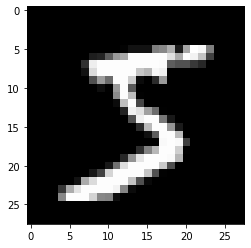

In [24]:
plt.imshow(np.squeeze(img0), 'gray')

In [25]:
# # convert data to torch.FloatTensor
# transform = transforms.ToTensor()
# # choose the training and testing datasets
# train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [26]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

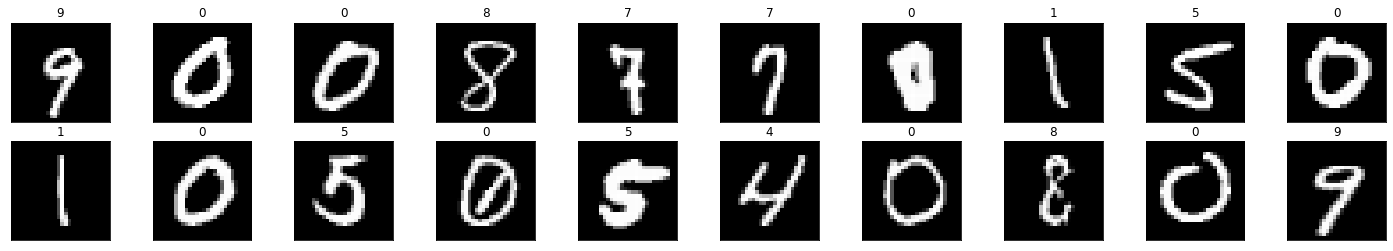

In [27]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

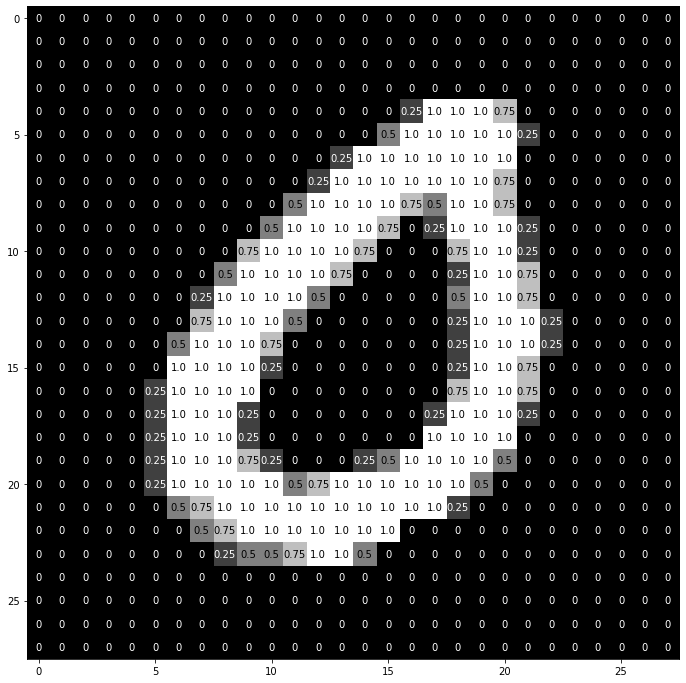

In [28]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# 베이스라인 MLP 모델 (지난 시간 예제)

# fully connected layer 2개, 마지막 fully connected output layer가 1개인 Multilayer Perceptron 네트워크 정의
### PyTorch에서는 class method인 forward에서 forward propagation을 정의하면 backward propagation 부분은 자동으로 구성해 줌 (autograd 기능)

In [108]:
# define NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input. 20개의 28*28 크기의 3차원 입력데이터([20,28,28])인 x를 28*28(=784) 크기의 2차원 데이터로 변환([20,784]).
        # 여기서 정의한 MLP 네트워크에서는 2차원 정보를 이용하지 않음
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

In [109]:
# initialize the NN
model_mlp = MLP()
print(model_mlp)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


model은 784 -> 512 -> 512 -> 10 의 구조를 가진 MLP

# Loss (Error)는 분류 문제에 사용하는 CrossEntropyLoss를 사용
# Gradient descent 알고리즘은 SGD(Stochastic Gradient Descent)를 사용
# Learning rate는 0.01

In [110]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model_mlp.parameters(),lr = 0.01)

# 학습 실행
### n_epochs를 50으로 설정 (학습에 시간이 걸리므로 지난 시간 결과를 참고해도 됨)
### 학습 1번 완료 후 train_data의 loss와 valid_data의 loss와 비교
### valid loss가 줄어들었으면 모델을 저장

In [111]:
# number of epochs to train the model
n_epochs = 50
#n_epochs = 25
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

start = time.time()
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################
    model_mlp.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_mlp(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
     ######################    
    # validate the model #
    ######################
    model_mlp.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_mlp(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss += loss.item() * data.size(0) # bug
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    end = time.time()
    print('Epoch: {} Elapsed time:{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        timer(start, end),
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_mlp.state_dict(), 'model_mlp.pt')
        valid_loss_min = valid_loss

Epoch: 1 Elapsed time:00:00:16.56 	Training Loss: 0.962746 	Validation Loss: 0.380365
Validation loss decreased (inf --> 0.380365).  Saving model ...
Epoch: 2 Elapsed time:00:00:32.30 	Training Loss: 0.361903 	Validation Loss: 0.287551
Validation loss decreased (0.380365 --> 0.287551).  Saving model ...
Epoch: 3 Elapsed time:00:00:48.14 	Training Loss: 0.283652 	Validation Loss: 0.237849
Validation loss decreased (0.287551 --> 0.237849).  Saving model ...
Epoch: 4 Elapsed time:00:01:04.04 	Training Loss: 0.233439 	Validation Loss: 0.201017
Validation loss decreased (0.237849 --> 0.201017).  Saving model ...
Epoch: 5 Elapsed time:00:01:19.97 	Training Loss: 0.199164 	Validation Loss: 0.178857
Validation loss decreased (0.201017 --> 0.178857).  Saving model ...
Epoch: 6 Elapsed time:00:01:35.74 	Training Loss: 0.171839 	Validation Loss: 0.155975
Validation loss decreased (0.178857 --> 0.155975).  Saving model ...
Epoch: 7 Elapsed time:00:01:51.60 	Training Loss: 0.151750 	Validation Loss

# 저장된 모델 로드

In [112]:
model_mlp.load_state_dict(torch.load('model_mlp.pt'))

<All keys matched successfully>

# test 데이터셋에 대해 인식률 계산

In [113]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model_mlp.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_mlp(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.058028

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 97% (985/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9824/10000)


# 약 98% 정확도 달성
# 실제 이미지를 보고 성능 확인
아래 예제에서는 하나의 미니배치(20개) 이미지를 확인함  

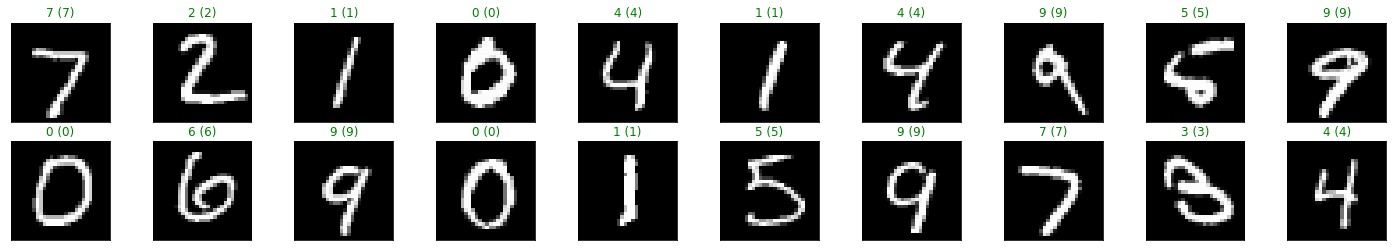

In [114]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get sample outputs
output = model_mlp(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
max_images = batch_size
for idx in np.arange(max_images):
    ax = fig.add_subplot(2, max_images/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

오류인 경우를 보기위해 틀릴 때까지 반복

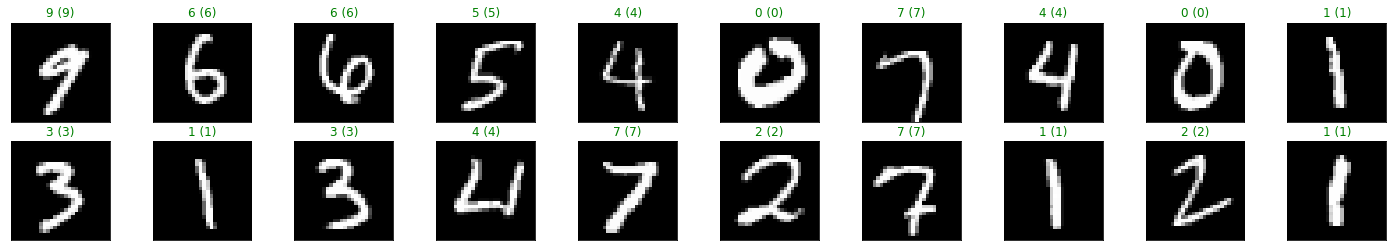

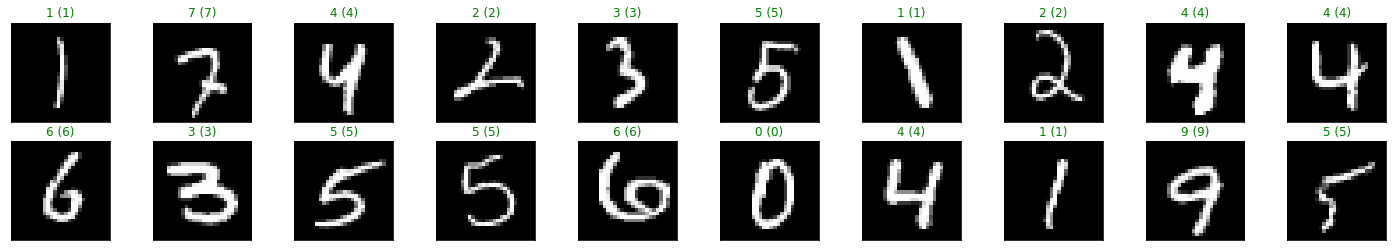

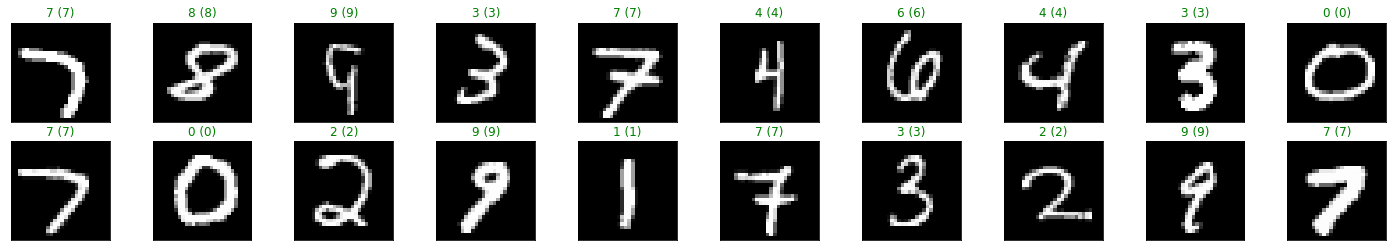

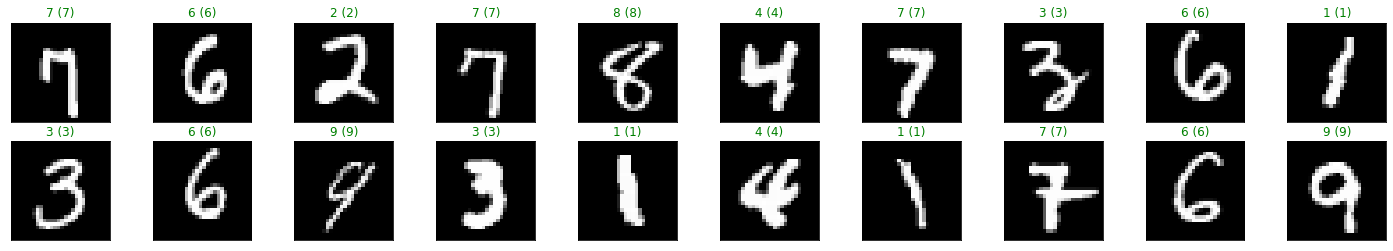

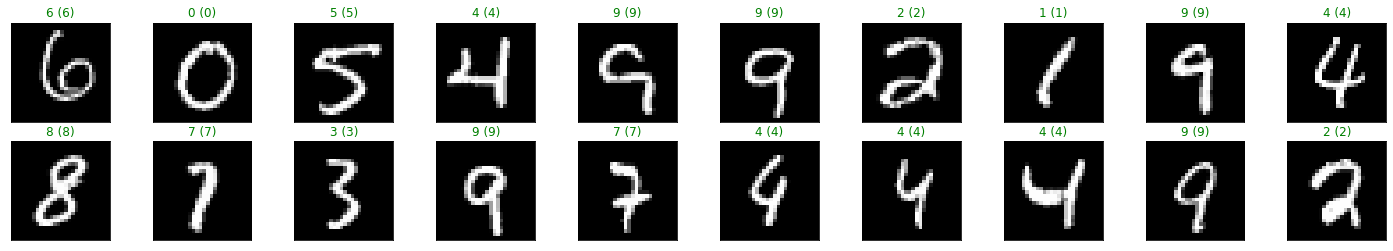

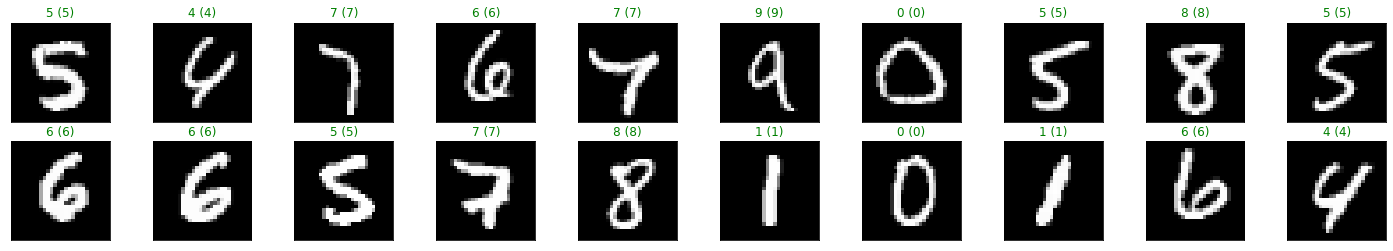

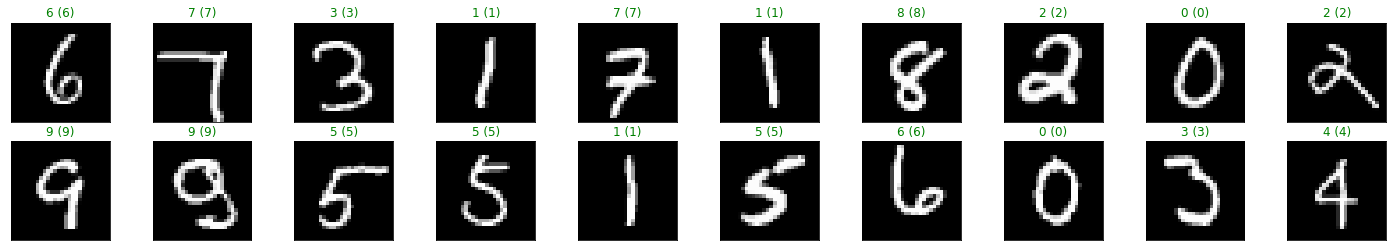

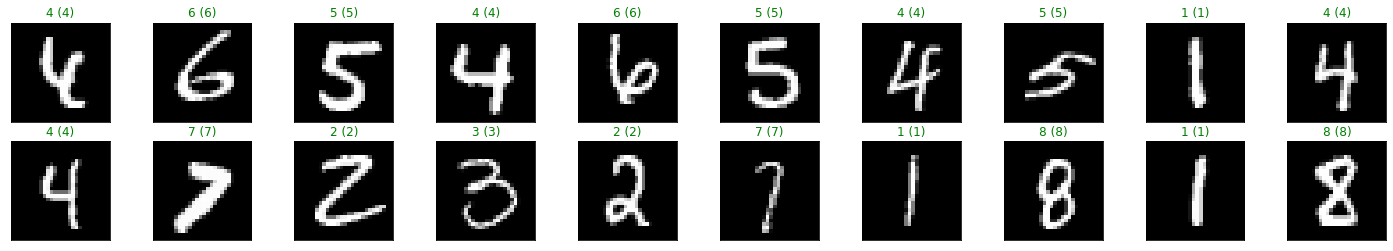

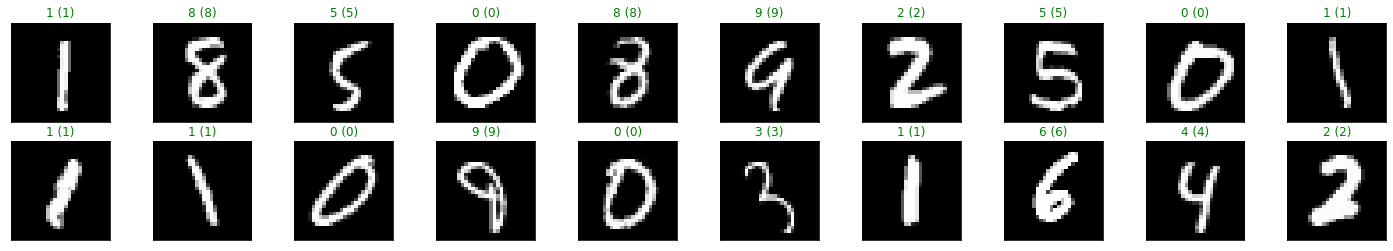

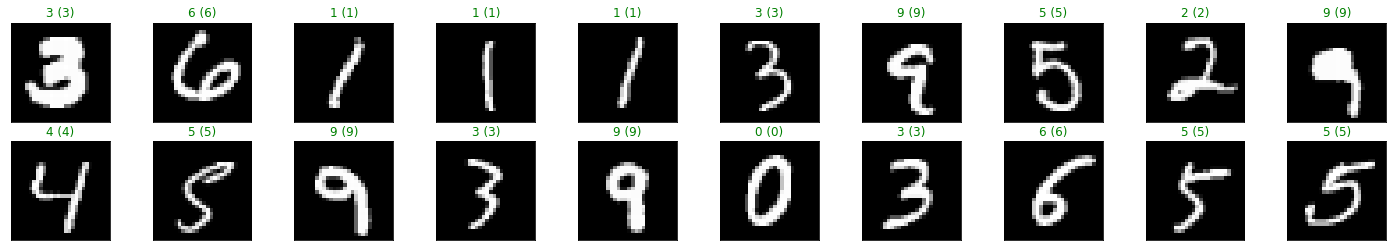

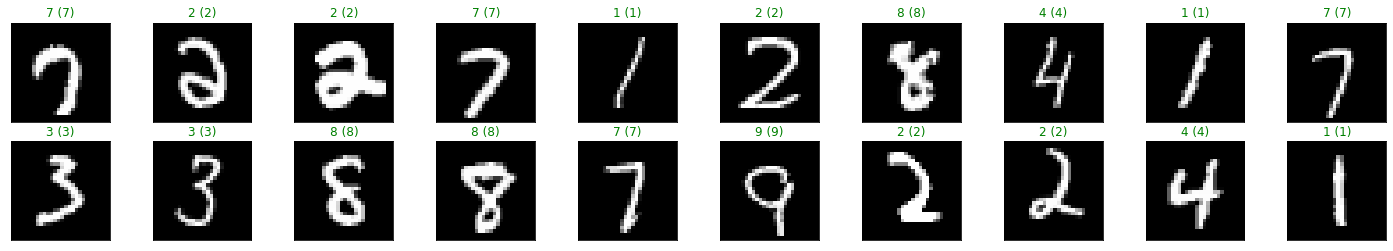

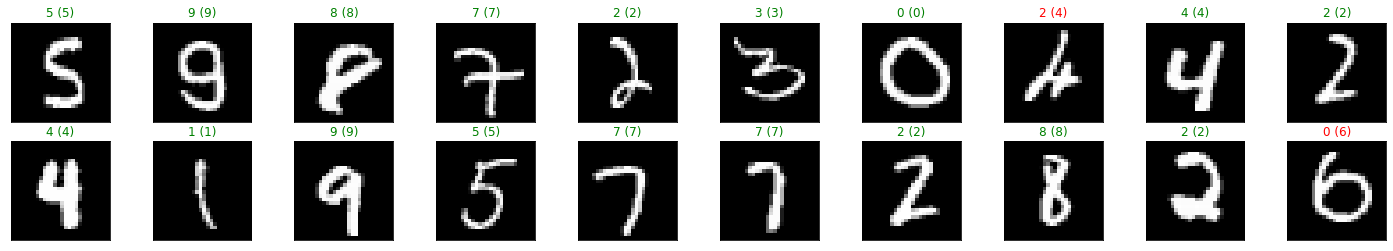

In [115]:
fail = False
for images, labels in dataiter:
    # get sample outputs
    output = model_mlp(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.numpy()
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"))
        if preds[idx] != labels[idx]:
            fail = True
    plt.show()
    if fail:
        break

**<font color="red" size="4">여기까지 지난 시간 예제와 동일</font>**

# 기본 구조 CNN (Vanailla CNN)

* 두 Conv 레이어 정의
    * 1 to 32 : 입력이 1 채널, 32개의 3x3 커널 학습, 이동(stride)은 한 칸씩
    * 32 to 64 : 입력이 32 채널, 64개의 3x3 커널 학습, 이동(stride)은 한 칸씩

* 레이어 별 dropout 정의
    * 25%를 dropout, 50%를 dropout


### no dropout, padding 1, two CONV layer->Max pool->two FC layer

nn.Conv2d(in_channels, out_channels, kernel_size)  


In [91]:
class MnistVanillaCNN(nn.Module):
    def __init__(self):
        super(MnistVanillaCNN, self).__init__() # 여기도 함께 바꿔줘야 함
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    # weight가 없는 activation function은 __init__에서 변수로 저장하지 않아도 된다
    def forward(self, x):
        x = self.conv1(x) # Conv -> ReLU
        x = F.relu(x)     # nn.ReLU와 동일한 계산을 수행. F.relu()는 계산, nn.ReLU()는 계산을 수행하는 모듈을 리턴함.
        x = F.max_pool2d(x, 2)  # max pooling 도 weight가 없음.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1) # flatten before linear layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [92]:
# initialize the NN
model_v = MnistVanillaCNN()
print(model_v)

MnistVanillaCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Vanilla CNN train

In [93]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
#optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
optimizer_v = torch.optim.SGD(model_v.parameters(),lr = 0.01)

In [94]:
# number of epochs to train the model
n_epochs = 25
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
start = time.time()
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model_v.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer_v.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_v(data)
        # calculate the loss
        loss = criterion(output, label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_v.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model_v.eval()  # prep model for evaluation
    for data, label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_v(data)
        # calculate the loss
        loss = criterion(output, label)
        # update running validation loss 
        valid_loss += loss.item() * data.size(0) # bug
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    end = time.time()
    print('Vanilla: Epoch:{} Elapsed time:{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        timer(start, end),
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_v.state_dict(), 'model_v.pt')
        valid_loss_min = valid_loss

Vanilla: Epoch:1 Elapsed time:00:00:58.75 	Training Loss: 0.659258 	Validation Loss: 0.217588
Validation loss decreased (inf --> 0.217588).  Saving model ...
Vanilla: Epoch:2 Elapsed time:00:01:56.48 	Training Loss: 0.164752 	Validation Loss: 0.120269
Validation loss decreased (0.217588 --> 0.120269).  Saving model ...
Vanilla: Epoch:3 Elapsed time:00:02:54.06 	Training Loss: 0.106417 	Validation Loss: 0.087477
Validation loss decreased (0.120269 --> 0.087477).  Saving model ...
Vanilla: Epoch:4 Elapsed time:00:03:51.78 	Training Loss: 0.079611 	Validation Loss: 0.083532
Validation loss decreased (0.087477 --> 0.083532).  Saving model ...
Vanilla: Epoch:5 Elapsed time:00:04:49.95 	Training Loss: 0.066491 	Validation Loss: 0.066559
Validation loss decreased (0.083532 --> 0.066559).  Saving model ...
Vanilla: Epoch:6 Elapsed time:00:05:47.86 	Training Loss: 0.055925 	Validation Loss: 0.075318
Vanilla: Epoch:7 Elapsed time:00:06:46.35 	Training Loss: 0.048011 	Validation Loss: 0.058750
Va

저장된 모델 로드

In [95]:
model_v.load_state_dict(torch.load('model_v.pt'))

<All keys matched successfully>

In [96]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10)) # 숫자별 맞힌 개수
class_total = list(0. for i in range(10)) # 숫자별 총 테스트 개수
model_v.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_v(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.030340

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 98% (1020/1032)
Test Accuracy of     3: 99% (1002/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 98% (881/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 98% (990/1009)

Test Accuracy (Overall): 99% (9902/10000)


In [97]:
# obtain one batch of test images
dataiter = iter(test_loader)

처음 20개 샘플 테스트

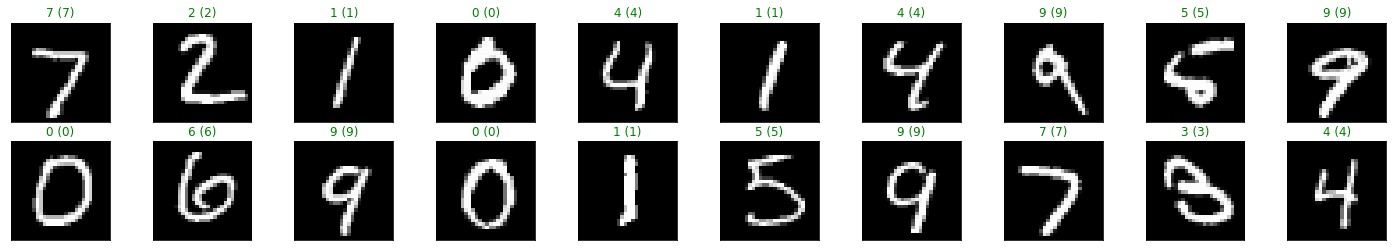

In [98]:
images, labels = dataiter.next()
# get sample outputs
output = model_v(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

오류인 경우를 보기위해 틀릴 때까지 반복

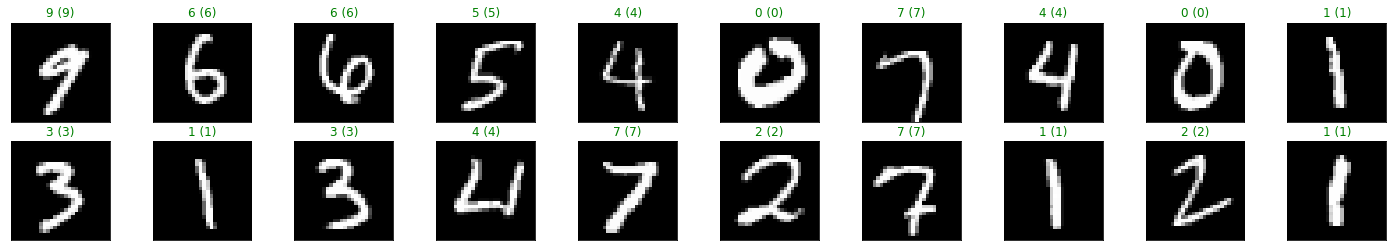

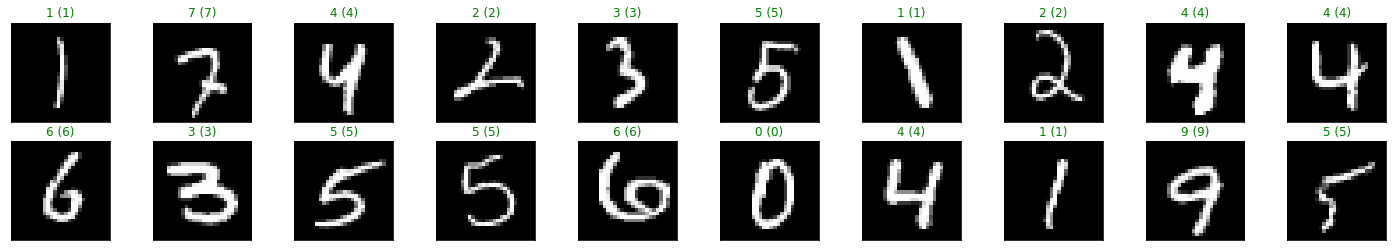

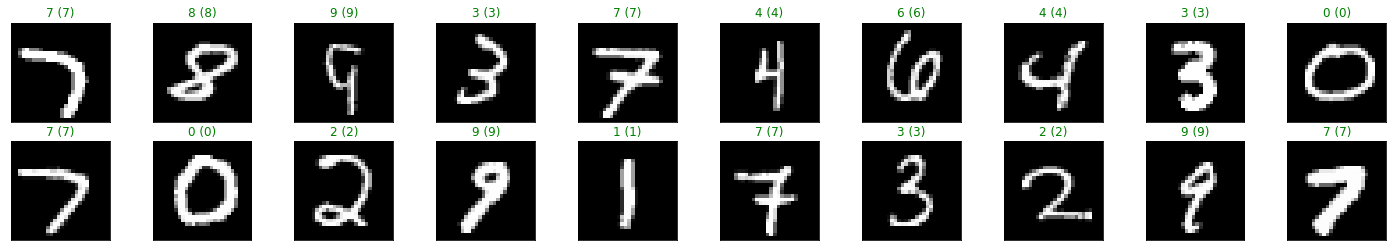

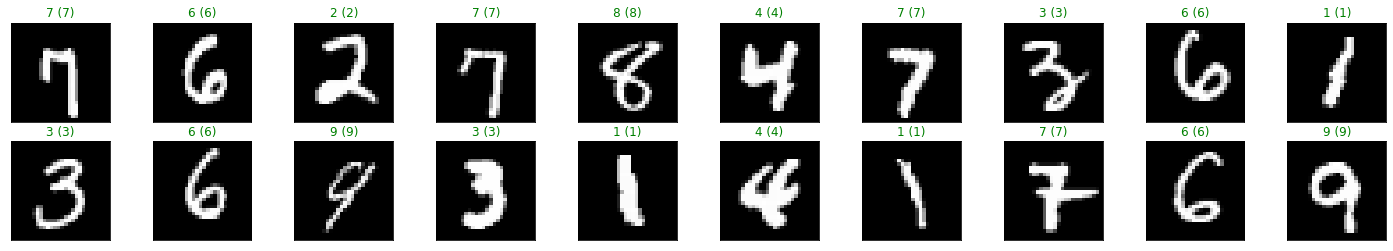

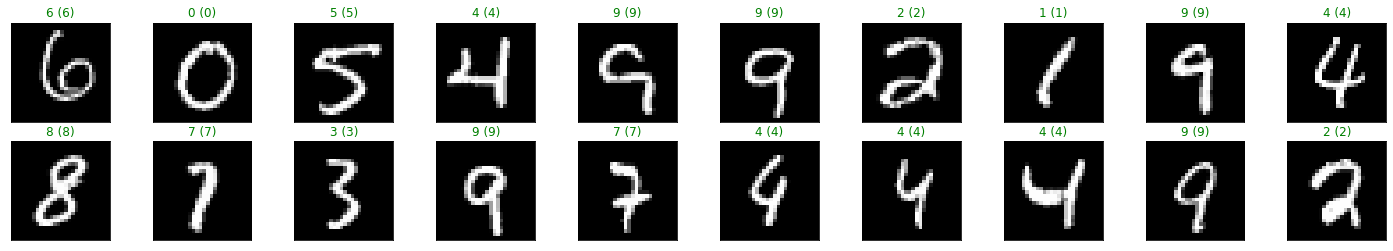

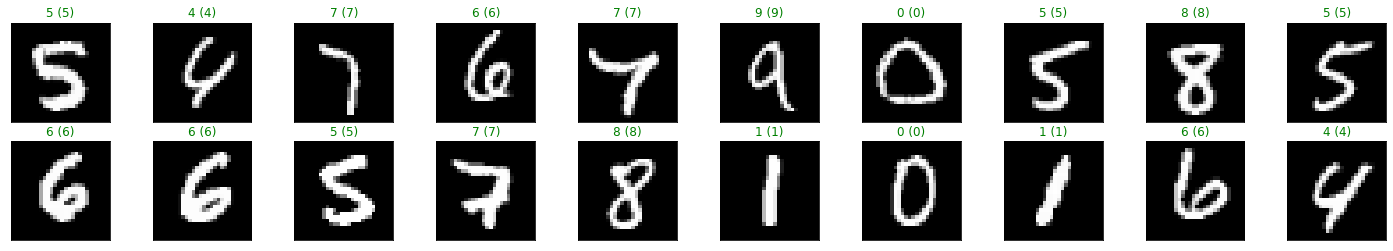

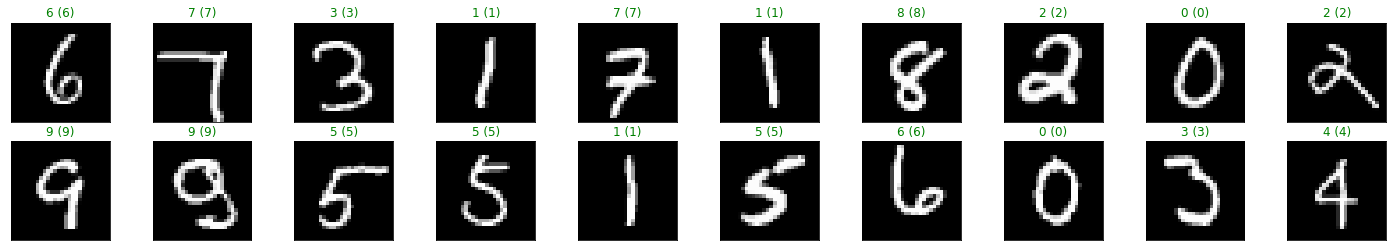

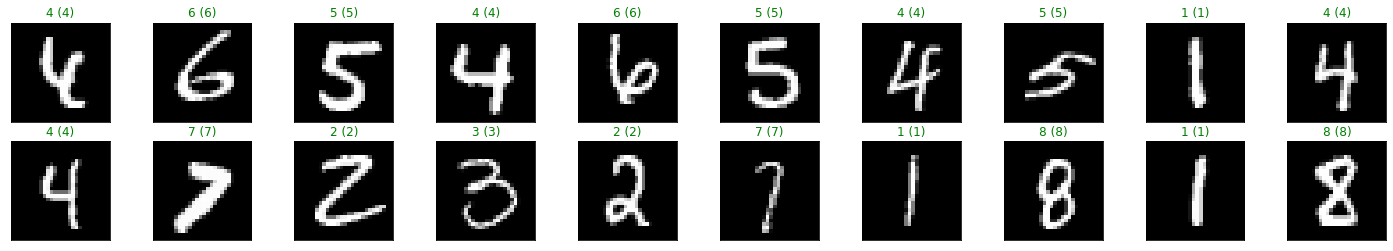

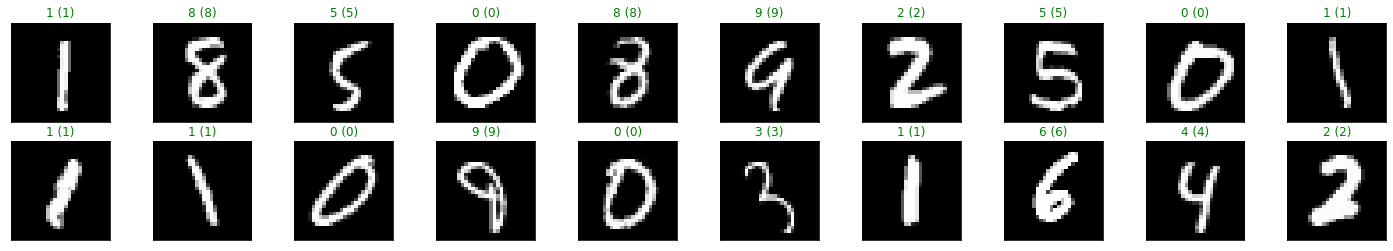

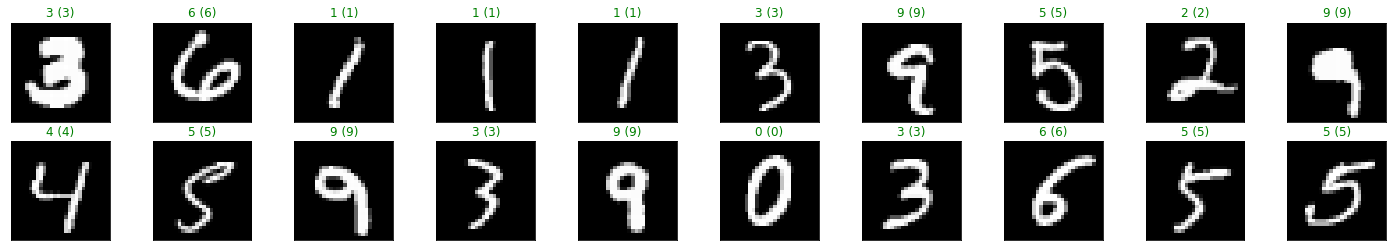

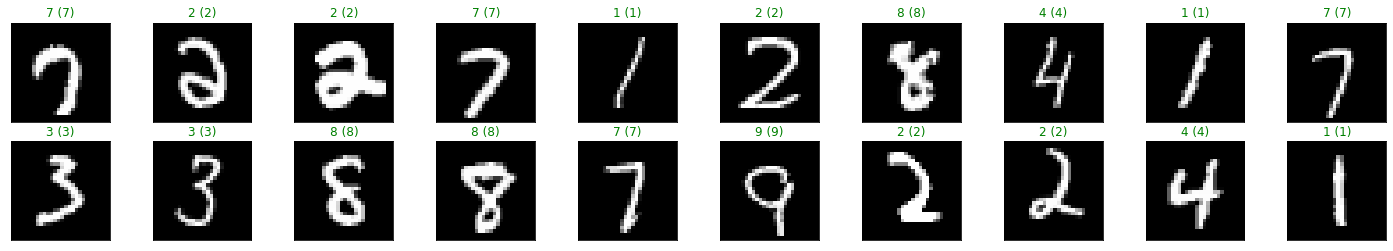

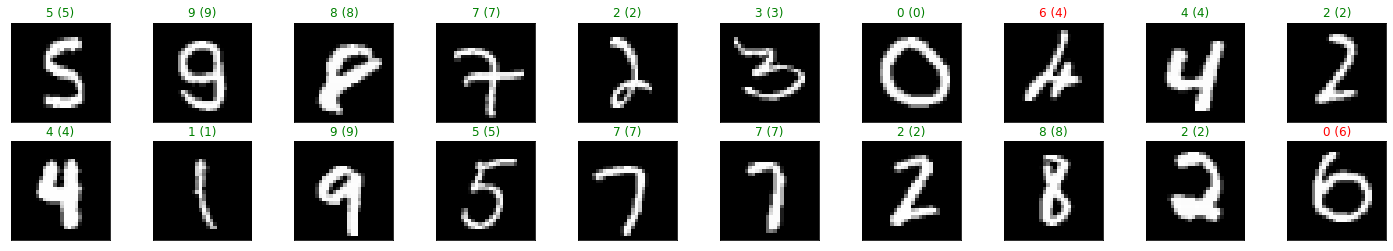

In [99]:
fail = False
for images, labels in dataiter:
    # get sample outputs
    output = model_v(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.numpy()
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"))
        if preds[idx] != labels[idx]:
            fail = True
    plt.show()
    if fail:
        break

## dropout regularization 적용

In [75]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__() # 여기도 함께 바꿔줘야 함
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    # weight가 없는 activation function은 __init__에서 변수로 저장하지 않아도 된다
    def forward(self, x):
        x = self.conv1(x) # Conv -> ReLU
        x = F.relu(x)     # nn.ReLU와 동일한 계산을 수행. F.relu()는 계산, nn.ReLU()는 계산을 수행하는 모듈을 리턴함.
        x = F.max_pool2d(x, 2) # max pooling 도 weight가 없음.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
        
# initialize the NN
model = MnistCNN()
print(model)

MnistCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [76]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [77]:
# number of epochs to train the model
n_epochs = 25
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
start = time.time()
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss += loss.item() * data.size(0) # bug
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    end = time.time()
    print('Vanilla: Epoch:{} Elapsed time:{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        timer(start, end),
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Vanilla: Epoch:1 Elapsed time:00:00:59.95 	Training Loss: 0.804331 	Validation Loss: 0.225725
Validation loss decreased (inf --> 0.225725).  Saving model ...
Vanilla: Epoch:2 Elapsed time:00:02:00.47 	Training Loss: 0.242446 	Validation Loss: 0.123775
Validation loss decreased (0.225725 --> 0.123775).  Saving model ...
Vanilla: Epoch:3 Elapsed time:00:03:00.82 	Training Loss: 0.167212 	Validation Loss: 0.085279
Validation loss decreased (0.123775 --> 0.085279).  Saving model ...
Vanilla: Epoch:4 Elapsed time:00:04:00.61 	Training Loss: 0.134315 	Validation Loss: 0.070539
Validation loss decreased (0.085279 --> 0.070539).  Saving model ...
Vanilla: Epoch:5 Elapsed time:00:05:00.33 	Training Loss: 0.114793 	Validation Loss: 0.063523
Validation loss decreased (0.070539 --> 0.063523).  Saving model ...
Vanilla: Epoch:6 Elapsed time:00:05:58.79 	Training Loss: 0.098055 	Validation Loss: 0.060630
Validation loss decreased (0.063523 --> 0.060630).  Saving model ...
Vanilla: Epoch:7 Elapsed ti

In [78]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [79]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.028118

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 99% (1022/1032)
Test Accuracy of     3: 99% (1007/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 99% (885/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 99% (1019/1028)
Test Accuracy of     8: 98% (963/974)
Test Accuracy of     9: 98% (993/1009)

Test Accuracy (Overall): 99% (9909/10000)


In [80]:
# obtain one batch of test images
dataiter = iter(test_loader)


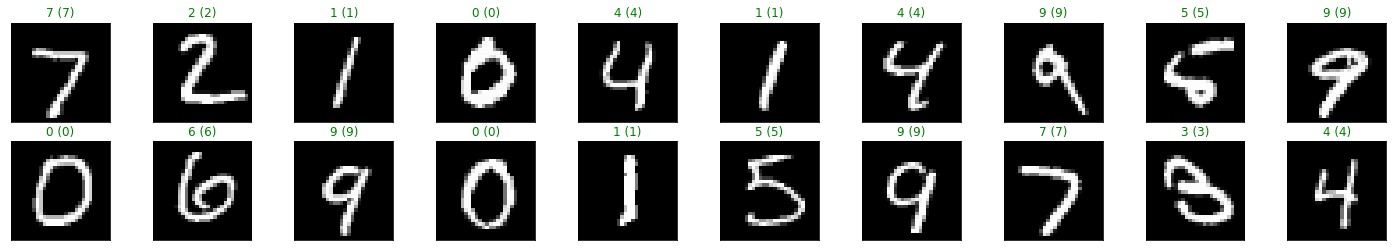

In [81]:
images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

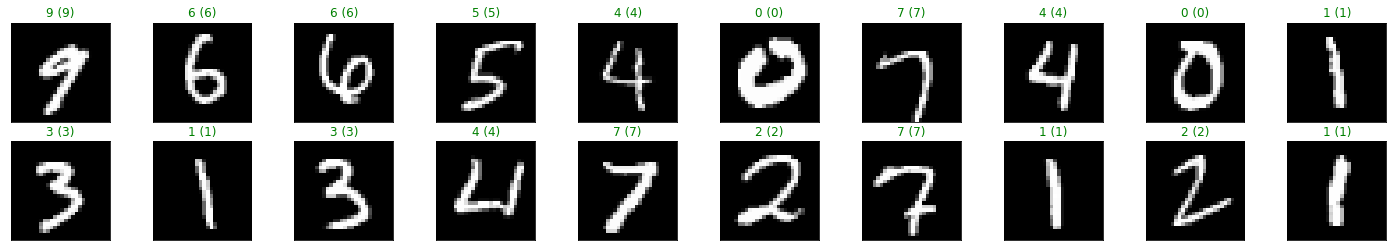

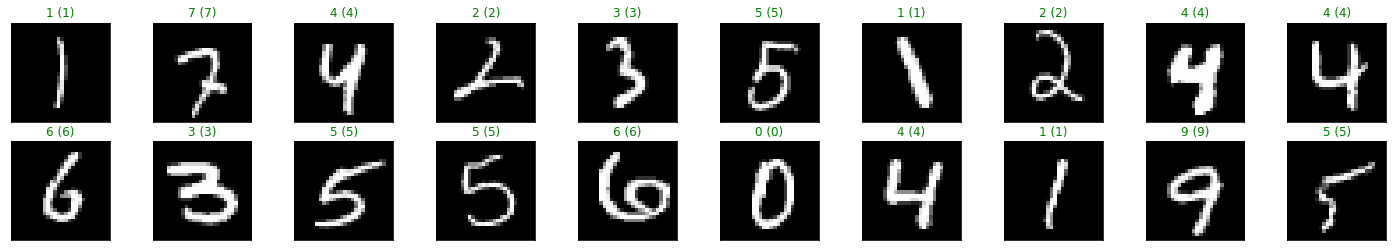

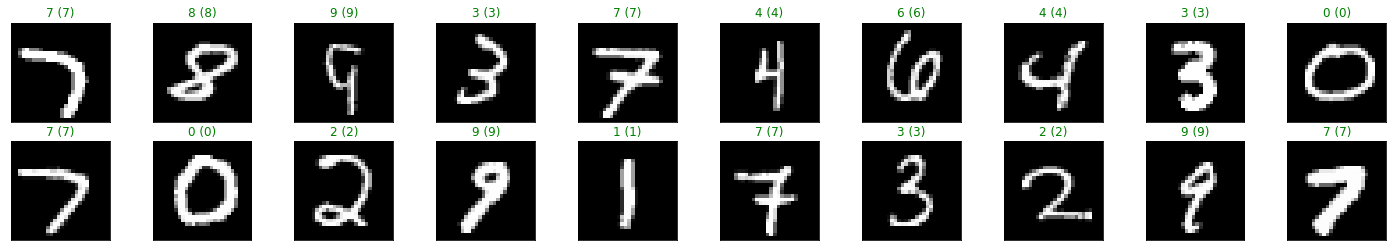

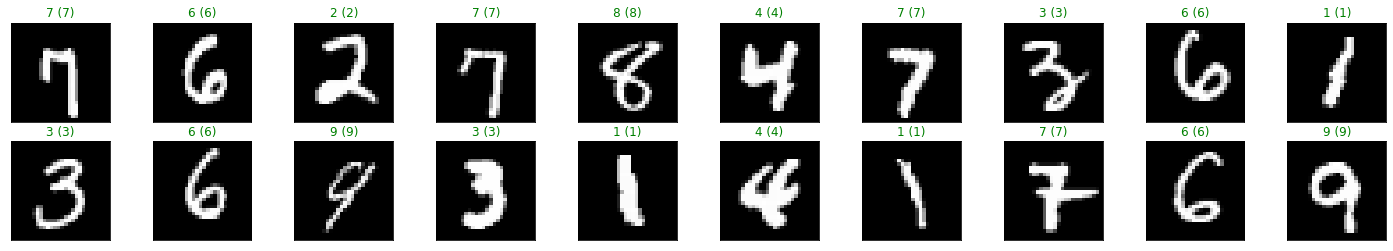

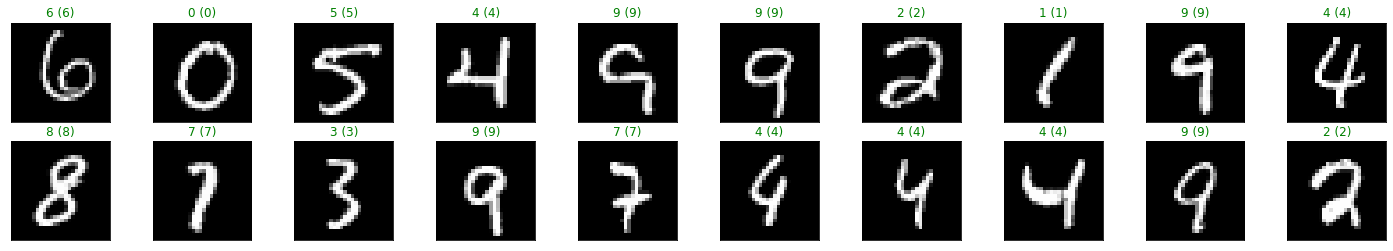

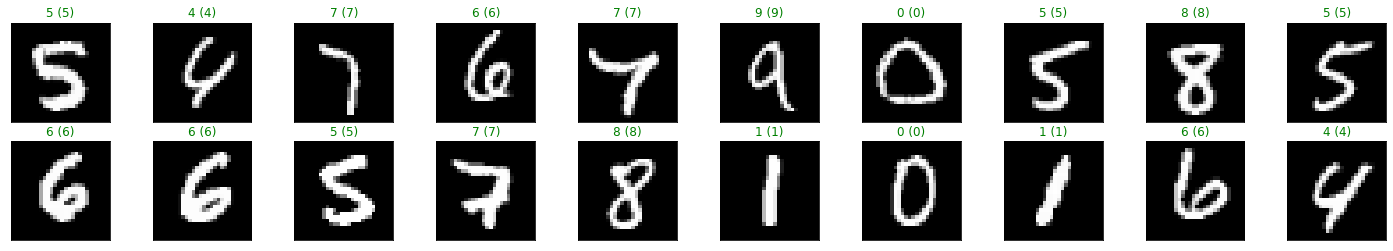

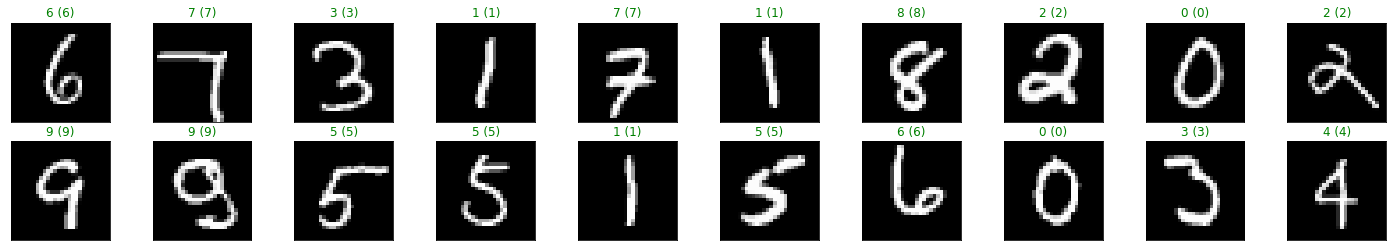

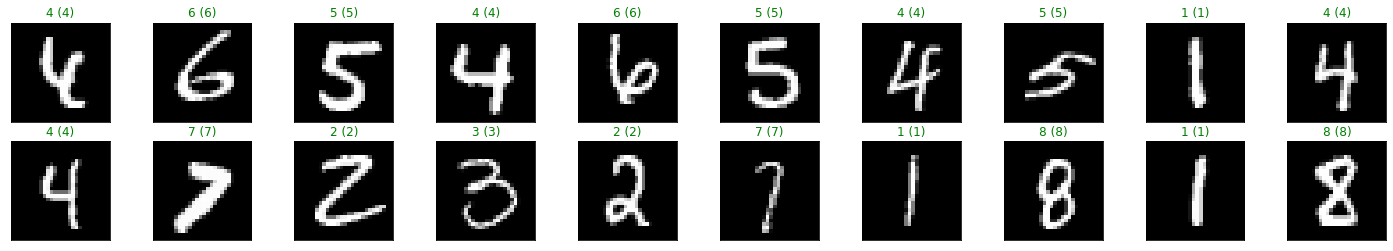

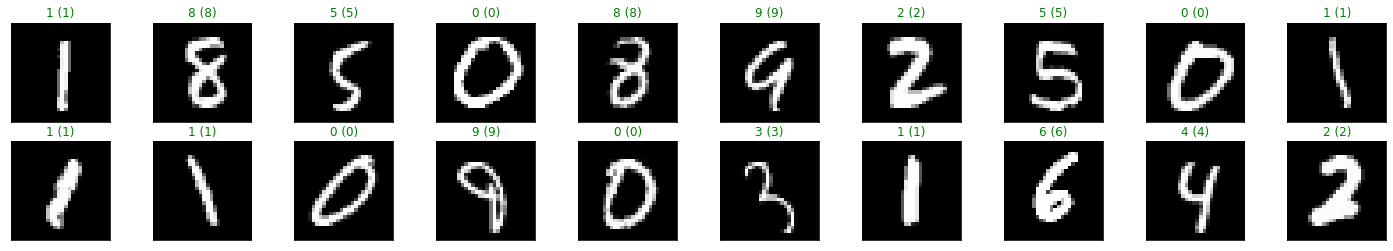

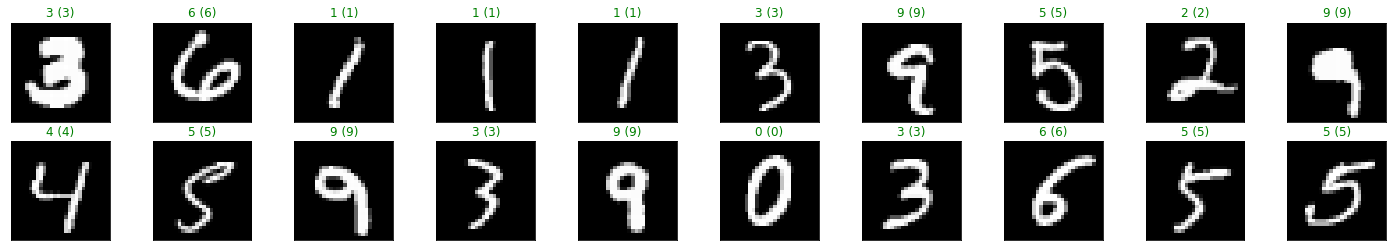

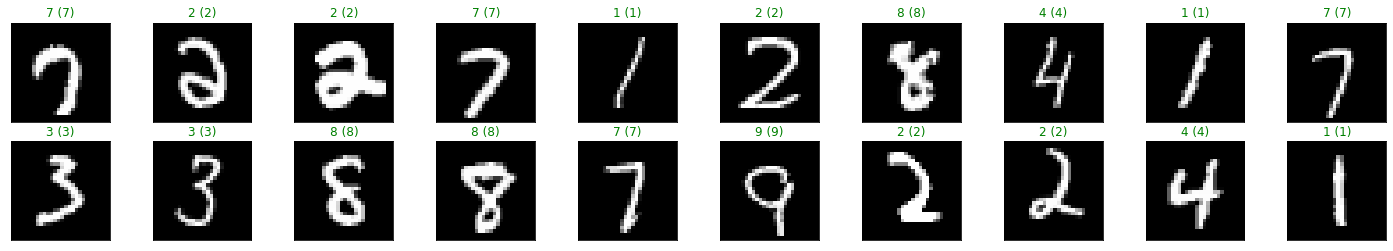

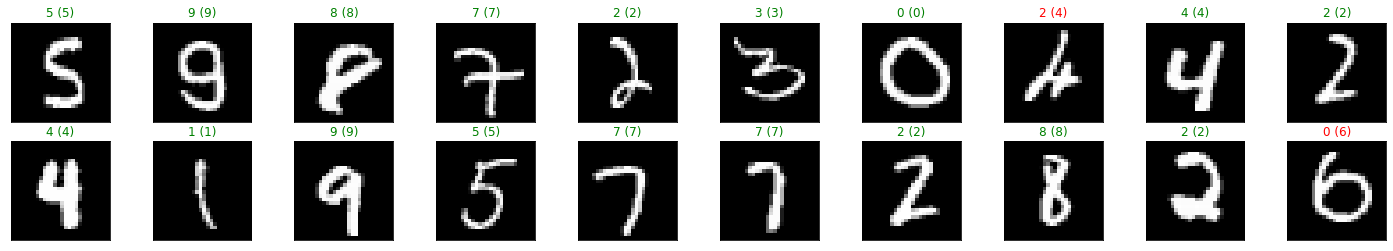

In [82]:
fail = False
for images, labels in dataiter:
    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.numpy()
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"))
        if preds[idx] != labels[idx]:
            fail = True
    plt.show()
    if fail:
        break

모델의 학습 파라미터 수 비교

In [83]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [84]:
count_parameters(model_v)

421642

In [85]:
count_parameters(model)

421642

In [86]:
count_parameters(model_mlp)

669706